# Gender Recogintion

## Imports

In [16]:
!pip install python_speech_features

In [17]:
import python_speech_features as mfcc
from scipy.io.wavfile import read
import numpy as np
import pandas as pd
import os
import time

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/ML-Project/LUMS_FALL2020_PROJECT_DATA.zip"

#### Data Reading Function

In [19]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [24]:
def dataset_generator(path):
  speaker=os.listdir(path)
  output=np.array([]);
  for a,s in enumerate(speaker):
    speaker_id=s
    # print(speaker_id)
    path_to_speaker=os.path.join(path,speaker_id)
    speaker_wav_files=os.listdir(path_to_speaker)
    for b,wav_files in enumerate(speaker_wav_files):
      wav_path=os.path.join(path_to_speaker,wav_files)
      sr, audio = read(wav_path)
      features = get_MFCC(audio, sr)
      features=np.append(features,speaker_id[-1])
      features=np.reshape(features,(1,features.shape[0]))
      if a==0 and b==0:
        # first iteration
        output= features
        continue
      output=np.append(output,features,axis=0)
  return output

#### Function Calls (Data Reading)

In [25]:
train_directory = '/content/Gender_Recognition/Train'
validation_directory = '/content/Gender_Recognition/Valid'
test_directory = '/content/Gender_Recognition/Test'

start = time.time()
df_train=dataset_generator(train_directory)
df_test=dataset_generator(test_directory)
df_valid=dataset_generator(validation_directory)
end = time.time()
print("Time taken: ", end-start)

Time taken:  54.72930717468262


In [32]:
df_train=pd.DataFrame(df_train)
df_test=pd.DataFrame(df_test)
df_valid=pd.DataFrame(df_valid)

df_train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,16.625840357400815,-2.4440964838053194,-2.4362814332790093,2.7695713791631005,-11.7776938311833,-33.40040668078567,-7.7643269606616965,-10.178410371201542,-3.3912857503562774,-8.256770677605916,0.7332681245244494,-3.2533923776093574,-7.017290476429802,M
1,15.729648587015804,-2.6753551214827276,1.3794553785273382,-5.663183017373065,-14.78964485748503,-23.36646079331186,-5.277256428421173,-10.729879123100753,-4.856369885908349,-5.319915095769968,-2.1830247692474196,-1.8543560487098432,-8.735967438730217,M
2,15.845916394690565,-3.183321230819048,-0.29659414883116625,-2.0403441449895348,-13.252018822126907,-25.393687175680668,-4.983250504880713,-10.889245293743073,-3.9591376792936264,-7.246220409763189,-0.8110758567647272,-3.630797037566415,-10.34601590376102,M
3,15.226181550118065,-3.701734474257167,-4.535543270738152,-6.577259613799018,-11.91809664241523,-20.434457882124097,-8.672198646802439,-10.641977929036177,-2.7831615758102983,-8.842032164466957,2.2076624935978133,-6.284745808238885,-8.442677418307323,M
4,16.381046093515284,-5.537617885951476,-3.0723950440095926,0.3746507353411828,-6.392170718761932,-28.295644528121134,-12.831385437891988,-11.27619348468831,-0.9689128965520613,-7.851816557095761,-1.5660260546535436,-0.8692621990953145,-9.34038928670469,M
5,16.002137433606983,-5.483413772568298,-1.1733601260372373,1.976772439634287,-8.631533625614692,-22.45309289486503,-11.458206932939941,-12.48141499866593,-9.083816210503269,-9.612843270253684,-0.7570826083307899,0.24523531218878517,-7.211055332997497,M
6,16.062410932836634,-4.753183982857377,-0.8671788188705954,0.26726113633842435,-7.713498193937122,-23.117332254411206,-5.709353876880287,-19.49529350137363,1.459333496898087,-9.365958265060135,3.1570948362982203,-6.897393987549023,-6.899447253571446,M
7,16.21958419358039,-4.525738776873643,-0.983187812897461,-0.13911779441545877,-7.518428876175537,-27.31338046359141,-11.742237891063763,-13.069987072985484,-6.957372328497123,-9.790434717405674,1.1711090510395894,-4.550967599687898,-2.6062956587451462,M
8,15.903360449737066,-6.050441715036798,0.65165863291249,-5.048534821784158,-12.603886203691125,-20.645901564585866,-9.760965827443219,-14.233221206472003,-2.7985142531176774,-6.64345355924308,1.134629239180194,-7.536673918242156,-6.431522484887522,M
9,14.958931199072156,-6.013887323127419,-1.931282898572698,-1.3352257347525394,-6.784128079714664,-20.199649100614582,-9.516657384991081,-15.040625090270083,-2.560513240754126,-11.850852790317743,-2.6350997188570067,-1.8614076726517337,-2.1128307896080236,M


#### Seperating the labels and features

In [39]:
Y_train=df_train[13]
Y_valid=df_valid[13]
Y_test=df_test[13]

X_train=df_train.drop(columns=[13])
X_valid=df_valid.drop(columns=[13])
X_test=df_test.drop(columns=[13])

X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,16.625840357400815,-2.4440964838053194,-2.4362814332790093,2.7695713791631005,-11.7776938311833,-33.40040668078567,-7.7643269606616965,-10.178410371201542,-3.3912857503562774,-8.256770677605916,0.7332681245244494,-3.2533923776093574,-7.017290476429802
1,15.729648587015804,-2.6753551214827276,1.3794553785273382,-5.663183017373065,-14.78964485748503,-23.36646079331186,-5.277256428421173,-10.729879123100753,-4.856369885908349,-5.319915095769968,-2.1830247692474196,-1.8543560487098432,-8.735967438730217
2,15.845916394690565,-3.183321230819048,-0.29659414883116625,-2.0403441449895348,-13.252018822126907,-25.393687175680668,-4.983250504880713,-10.889245293743073,-3.9591376792936264,-7.246220409763189,-0.8110758567647272,-3.630797037566415,-10.34601590376102
3,15.226181550118065,-3.701734474257167,-4.535543270738152,-6.577259613799018,-11.91809664241523,-20.434457882124097,-8.672198646802439,-10.641977929036177,-2.7831615758102983,-8.842032164466957,2.2076624935978133,-6.284745808238885,-8.442677418307323
4,16.381046093515284,-5.537617885951476,-3.0723950440095926,0.3746507353411828,-6.392170718761932,-28.295644528121134,-12.831385437891988,-11.27619348468831,-0.9689128965520613,-7.851816557095761,-1.5660260546535436,-0.8692621990953145,-9.34038928670469


In [36]:
Y_train.head(5)

0    M
1    M
2    M
3    M
4    M
Name: 13, dtype: object

#### Normalizing Data

##### Convert to numeric

In [40]:
X_train = X_train.apply(pd.to_numeric)
X_valid = X_valid.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

##### Normalizaion function

In [41]:
def normalize(array):
  means=np.mean(array, axis=0)
  std=np.std(array, axis=0)
  array=(array-means)/std
  return array

##### Normalization Function Calls

In [42]:
normalised_train=normalize(X_train)
normalised_valid=normalize(X_valid)
normalised_test=normalize(X_test)

normalised_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.497132,-0.338737,0.018409,0.177703,-0.677046,-3.119393,0.342772,-0.415862,0.083645,-0.534473,0.736127,0.196445,-0.104188
1,0.989159,-0.378046,0.540159,-1.067993,-1.044045,-1.827931,0.705670,-0.489183,-0.142725,-0.084847,0.257483,0.431865,-0.436930
2,1.055061,-0.464389,0.310982,-0.532823,-0.856689,-2.088854,0.748569,-0.510371,-0.004094,-0.379760,0.482657,0.132938,-0.748641
3,0.703788,-0.552508,-0.268636,-1.203021,-0.694154,-1.450555,0.210301,-0.477496,0.177605,-0.624075,0.978116,-0.313650,-0.380148
4,1.358379,-0.864569,-0.068571,-0.176077,-0.020833,-2.462363,-0.396581,-0.561817,0.457924,-0.472475,0.358749,0.597630,-0.553948


##### Bias Addition

In [43]:
normalised_train.insert(0, 'Bias', 1)
normalised_valid.insert(0, 'Bias', 1)
normalised_test.insert(0, 'Bias', 1)

normalised_train.head(5)

,Bias,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,1.497132,-0.338737,0.018409,0.177703,-0.677046,-3.119393,0.342772,-0.415862,0.083645,-0.534473,0.736127,0.196445,-0.104188
1,1,0.989159,-0.378046,0.540159,-1.067993,-1.044045,-1.827931,0.705670,-0.489183,-0.142725,-0.084847,0.257483,0.431865,-0.436930
2,1,1.055061,-0.464389,0.310982,-0.532823,-0.856689,-2.088854,0.748569,-0.510371,-0.004094,-0.379760,0.482657,0.132938,-0.748641
3,1,0.703788,-0.552508,-0.268636,-1.203021,-0.694154,-1.450555,0.210301,-0.477496,0.177605,-0.624075,0.978116,-0.313650,-0.380148
4,1,1.358379,-0.864569,-0.068571,-0.176077,-0.020833,-2.462363,-0.396581,-0.561817,0.457924,-0.472475,0.358749,0.597630,-0.553948


#### Joining the labels and features back

In [44]:
normalised_train['Labels']=Y_train
normalised_valid['Labels']=Y_valid
normalised_test['Labels']=Y_test

normalised_train.tail(5)

,Bias,0,1,2,3,4,5,6,7,8,9,10,11,12,Labels
1075,1,-0.768841,0.302662,-1.119616,-1.960898,0.322413,-0.962396,0.736461,1.091055,-0.498266,0.291000,0.612938,-0.409916,-0.163622,M
1076,1,-0.461367,0.427527,-1.290991,-1.432430,0.185477,-0.981379,0.187886,0.958515,-0.801962,0.422880,0.397372,-0.593217,0.444585,M
1077,1,-0.635344,0.485963,-1.110414,-1.481278,0.542846,-1.259815,-0.330252,0.804197,-0.561281,0.109152,0.708195,-0.421818,0.303583,M
1078,1,-0.976472,-0.156155,-1.189636,-1.681591,0.824913,-0.977736,-0.079518,0.771610,-0.576036,0.303676,0.321114,-0.582438,0.036633,M
1079,1,-0.600382,0.454791,-1.028217,-1.237273,0.418662,-1.139402,0.156816,1.033867,-0.890037,-0.075121,0.624500,-0.263837,0.354221,M


In [ ]:
se

#### Saving the data in a CSV file 
*(to avoid redoing everything we did earlier)*

In [45]:
normalised_train.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ML-Project/train_GR.csv')
normalised_valid.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ML-Project/valid_GR.csv')
normalised_test.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ML-Project/test_GR.csv')

#### In case of restart, start here

##### Read data

In [ ]:
normalised_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML-Project/train_GR.csv')
normalised_valid=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML-Project/train_GR.csv')
normalised_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML-Project/train_GR.csv')

# normalised_train=normalised_train.drop('Unnamed: 0',axis=1)
# normalised_test=normalised_test.drop('Unnamed: 0',axis=1)
# normalised_valid=normalised_valid.drop('Unnamed: 0',axis=1)

normalised_train.head(5)

## Encoding

In [46]:
encoded_labels_test = pd.get_dummies(normalised_test['Labels'])
encoded_labels_train = pd.get_dummies(normalised_train['Labels'])
encoded_labels_valid = pd.get_dummies(normalised_valid['Labels'])
labels=encoded_labels_train.columns
encoded_labels_train.shape

(1080, 2)

In [58]:
X_train=normalised_train.to_numpy()[:,0:14]
# Y_train=normalised_train.to_numpy()[:,-1]
X_test=normalised_test.to_numpy()[:,0:14]
Y_test=normalised_test.to_numpy()[:,-1]
X_valid=normalised_valid.to_numpy()[:,0:14]
# Y_valid=normalised_valid.to_numpy()[:,-1]

## Multinomial Logistic Regression

#### Softmax

In [48]:
def softmax(x):
    x=np.array(x, dtype=float)
    # print(x)
    return np.exp(x+0.001) / np.sum(np.exp(x+0.001), axis=0)

#### Cost (Cross Entropy)

In [49]:
"def cross_entropy_loss(X,Y,theta):
  m=X_train.shape[0]
  output = np.dot(X,theta)
  predictions=np.apply_along_axis(softmax,1,output)
  predictions=np.log(predictions+0.001) 
  output=(np.multiply(predictions,Y))*-1
  output=output.sum(axis=1)
  return np.sum(output)/(m)

#### Gradient Descent

In [50]:
def gradient_descent(X,X_valid,theta,Y,Y_valid,alpha,iterations):
  # X holds training data and is in the shape (m,f)
  # where m is training examples and f is features
  # theta are weight matrixes in the shape (f,c)
  # where f are features and c is number of classes
  # Y is our onehot encoded label matrix in the shape(m,c) where m is exmaples
  # c is classes
  m=X_train.shape[0]
  training_cost=[]
  validation_cost=[]
  for epoch in range(iterations):
    # calculate output
    output = np.dot(X,theta)
    # output is (m,c)
    #put them through softmax to get predictions
    predictions=np.apply_along_axis(softmax,1,output) 
    # now we will calculate error
    error=np.array(predictions-Y)
    # create an array for the derivatives
    # djs will have shape (c,f)
    djs=[]
    for i in range(X.shape[1]):
      # we will multiply every column of the error with the column of x
      a = error * X[:,i][:, None]
      b=(a.sum(axis=0))/m
      # b is going to be an array of c elements
      # we are going to append b to the djs array so get an array of (14,c)
      djs.append(b)
    # update
    djs=np.array(djs)
    theta=theta-(alpha*djs)
    # calculate training costs
    # calculate validation costs
    # append and return that
    training_cost.append(cross_entropy_loss(X,Y,theta))
    validation_cost.append(cross_entropy_loss(X_valid,Y_valid,theta))
  return theta,training_cost, validation_cost  


#### Predict Results

In [60]:
def predict(X,theta,labels):
  output = np.dot(X,theta)
  predictions=np.apply_along_axis(softmax,1,output)
  answers=np.apply_along_axis(np.argmax,1,predictions)
  results=[labels[l] for l in answers]
  return results

#### Loss Plotting

In [51]:
def plotting(training_cost, validation_cost):
  plt.plot(training_cost,label="training")
  plt.plot(validation_cost,label="validation")
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('costs')
  plt.title('Multinomial logistic regression costs')
  plt.show()

#### Report Results

In [53]:
def report(X_test, theta, Y_test):
  pred=predict(X_test,theta,labels)
  print("Prediction Accuracy is %.2f %%"% accuracy_score(Y_test, pred))
  print("Confusion Matrix:\n", confusion_matrix(Y_test, pred))
  print("Classification Report:\n", classification_report(Y_test, pred))

#### Validation

In [62]:
def validation(hyperParameters, X_train, X_valid, encoded_labels_train, encoded_labels_valid, X_test, Y_test):
  for parameters in hyperParameters:
    theta= np.random.rand(14,2) # (13 features + bias, 2 classes)
    iterations=parameters[0]
    alpha=parameters[1]
    theta,training_cost,validation_cost=gradient_descent(X_train,X_valid,theta,encoded_labels_train,encoded_labels_valid,alpha,iterations)
    
    print("_______________________________________________")
    print("Learning Rate: ", alpha)
    print("Epochs: ", iterations)
    
    plotting(training_cost, validation_cost)
    report(X_test, theta, Y_test)

#### Tuning Hyperparameters

_______________________________________________
Learning Rate:  0.1
Epochs:  250


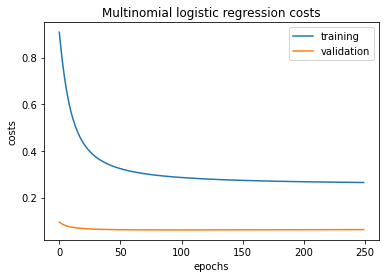

Prediction Accuracy is 0.84 %
Confusion Matrix:
 [[ 23  17]
 [ 11 119]]
Classification Report:
               precision    recall  f1-score   support

           F       0.68      0.57      0.62        40
           M       0.88      0.92      0.89       130

    accuracy                           0.84       170
   macro avg       0.78      0.75      0.76       170
weighted avg       0.83      0.84      0.83       170

_______________________________________________
Learning Rate:  0.1
Epochs:  500


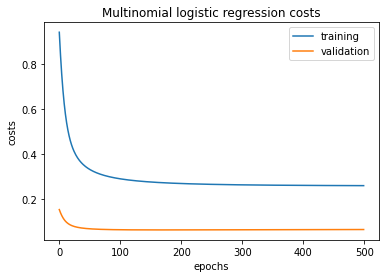

Prediction Accuracy is 0.84 %
Confusion Matrix:
 [[ 23  17]
 [ 11 119]]
Classification Report:
               precision    recall  f1-score   support

           F       0.68      0.57      0.62        40
           M       0.88      0.92      0.89       130

    accuracy                           0.84       170
   macro avg       0.78      0.75      0.76       170
weighted avg       0.83      0.84      0.83       170

_______________________________________________
Learning Rate:  0.1
Epochs:  1000


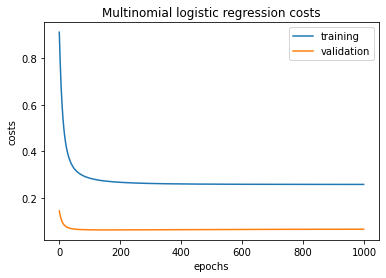

Prediction Accuracy is 0.84 %
Confusion Matrix:
 [[ 23  17]
 [ 11 119]]
Classification Report:
               precision    recall  f1-score   support

           F       0.68      0.57      0.62        40
           M       0.88      0.92      0.89       130

    accuracy                           0.84       170
   macro avg       0.78      0.75      0.76       170
weighted avg       0.83      0.84      0.83       170

_______________________________________________
Learning Rate:  0.01
Epochs:  250


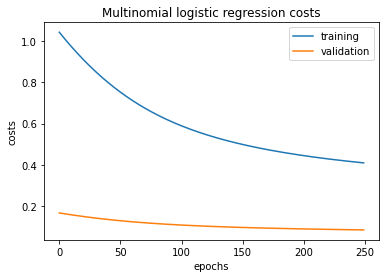

Prediction Accuracy is 0.84 %
Confusion Matrix:
 [[ 22  18]
 [ 10 120]]
Classification Report:
               precision    recall  f1-score   support

           F       0.69      0.55      0.61        40
           M       0.87      0.92      0.90       130

    accuracy                           0.84       170
   macro avg       0.78      0.74      0.75       170
weighted avg       0.83      0.84      0.83       170

_______________________________________________
Learning Rate:  0.01
Epochs:  500


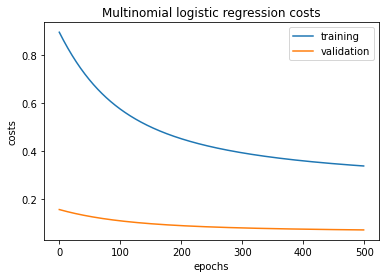

Prediction Accuracy is 0.88 %
Confusion Matrix:
 [[ 30  10]
 [ 10 120]]
Classification Report:
               precision    recall  f1-score   support

           F       0.75      0.75      0.75        40
           M       0.92      0.92      0.92       130

    accuracy                           0.88       170
   macro avg       0.84      0.84      0.84       170
weighted avg       0.88      0.88      0.88       170

_______________________________________________
Learning Rate:  0.01
Epochs:  1000


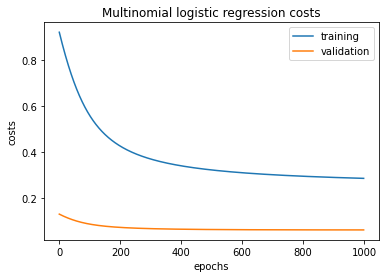

Prediction Accuracy is 0.82 %
Confusion Matrix:
 [[ 21  19]
 [ 11 119]]
Classification Report:
               precision    recall  f1-score   support

           F       0.66      0.53      0.58        40
           M       0.86      0.92      0.89       130

    accuracy                           0.82       170
   macro avg       0.76      0.72      0.74       170
weighted avg       0.81      0.82      0.82       170

_______________________________________________
Learning Rate:  0.001
Epochs:  250


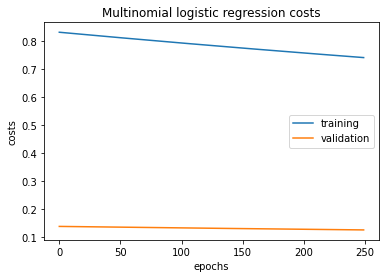

Prediction Accuracy is 0.59 %
Confusion Matrix:
 [[35  5]
 [64 66]]
Classification Report:
               precision    recall  f1-score   support

           F       0.35      0.88      0.50        40
           M       0.93      0.51      0.66       130

    accuracy                           0.59       170
   macro avg       0.64      0.69      0.58       170
weighted avg       0.79      0.59      0.62       170

_______________________________________________
Learning Rate:  0.001
Epochs:  500


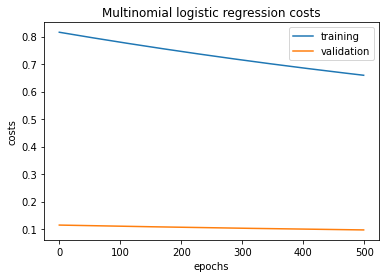

Prediction Accuracy is 0.69 %
Confusion Matrix:
 [[28 12]
 [41 89]]
Classification Report:
               precision    recall  f1-score   support

           F       0.41      0.70      0.51        40
           M       0.88      0.68      0.77       130

    accuracy                           0.69       170
   macro avg       0.64      0.69      0.64       170
weighted avg       0.77      0.69      0.71       170

_______________________________________________
Learning Rate:  0.001
Epochs:  1000


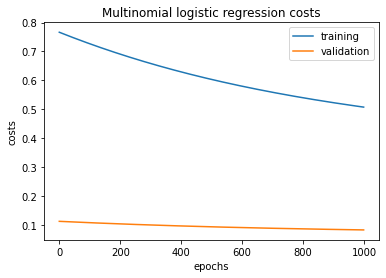

Prediction Accuracy is 0.91 %
Confusion Matrix:
 [[ 35   5]
 [ 10 120]]
Classification Report:
               precision    recall  f1-score   support

           F       0.78      0.88      0.82        40
           M       0.96      0.92      0.94       130

    accuracy                           0.91       170
   macro avg       0.87      0.90      0.88       170
weighted avg       0.92      0.91      0.91       170



In [64]:
hyperParameters = [[250, 0.1], [500, 0.1], [1000, 0.1], [250, 0.01], [500, 0.01], [1000, 0.01], [250, 0.001], [500, 0.001], [1000, 0.001]]
validation(hyperParameters, X_train, X_valid, encoded_labels_train, encoded_labels_valid, X_test, Y_test)

## Analysis

The validation is done on a wide range of hypermeters (not just the ones in above code block). It seems the best results we get keeping in mind both Accuracy and F1 Score are with the hyperparameters: *learning rate = 0.001, number of epochs = 1000*

In [ ]:
finalParameters = [[1000, 0.001]]
validation(finalParameters, X_train, X_valid, encoded_labels_train, encoded_labels_valid, X_test, Y_test)

#### Results

*   Accuracy: 0.91
*   F1 Score (macro avg): 0.88

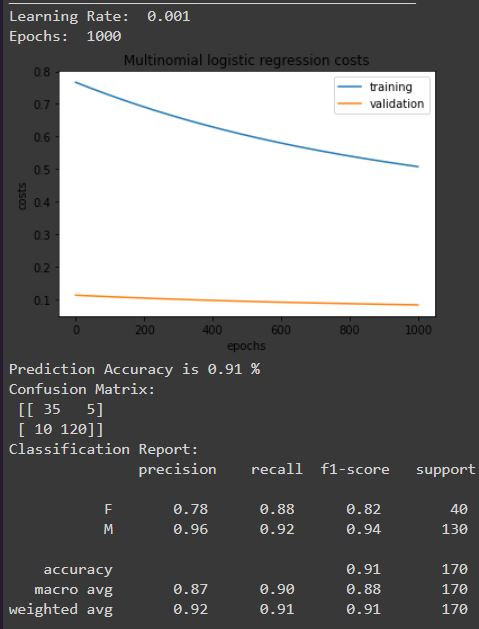